# Introduction
In the last notebook we saw that MLPs with multiple layers are pretty good at coming up with names. In this notebook we dive deep into the network to understand what is going on and how to do diagnostics.

We will go though the following:

* Initialization of Weights
* Activations

# Libraries

In [1]:
%matplotlib inline
%config IPCompleter.use_jedi=False

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data
This step is pretty much equiviant of that in the previous notebook, so we will not go into depth on how the dataset is created.

### Reading the Data

In [3]:
# Reading names into a list
with open('../../data/names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

### Creating Vocabulary

In [4]:
# Building the vocabulary (character to/from index)
chars = sorted(list(set(''.join(names))))
chr_to_idx = {s:i+1 for i,s in enumerate(chars)}; print(chr_to_idx)
chr_to_idx['.'] = 0
idx_to_chr = {i:s for s,i in chr_to_idx.items()}; print(idx_to_chr)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Preparing Dataset

In [5]:
def build_dataset(words: list, block_size: int = 3, verbose: bool = False) -> tuple:
    """
    Description:
        Take a list of words and creates Xs and Ys give
        a block size. E.g. block_size=3 for emma would 
        result in:
            ... ---> e  
            ..e ---> m  
            .em ---> m  
            emm ---> a  
            mma ---> . 
        Stored in a (n, 3) tensor
    Inputs:
        words: List of words
        block_size: The context window
        verbose: Where to print the outputs
    Ouputs:
        A (n, block_size) tensor with Xs
        A (n) tensor with Ys
    """
    X, Y = [], []
    for word in words:
        if verbose:
            print(word)
        context = [0] * block_size
        for char in word + '.':
            idx = chr_to_idx[char]
            X.append(context)
            Y.append(idx)
            if verbose:
                print(''.join(idx_to_chr[i] for i in context), idx_to_chr[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [6]:
# Putting names in random order
random.shuffle(names)

# Creating split indices
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

In [7]:
# Building training, validation and test sets
Xtr, Ytr = build_dataset(names[:n1]); print(Ytr.size())
Xval, Yval = build_dataset(names[n1:n2]); print(Yval.size())
Xtest, Ytest = build_dataset(names[n2:]); print(Ytest.size())

torch.Size([182412])
torch.Size([22892])
torch.Size([22842])


# Building Network
We build a similar MLP to that in the previous notebook.

In [8]:
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden])
b1 = torch.randn([n_hidden])
W2 = torch.randn([n_hidden, vocab_size])
b2 = torch.randn([vocab_size])

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


# Training
We use the same training loop as in the previous notebook. We have, however, refactored a bit, and defined a method for calculating the loss without messing with the gradients.

In [9]:
@torch.no_grad() # Decorator disables gradient tracking
def split_loss(split: str = 'train', print_loss: bool = False) -> None:
    """
    Description:
        Prints the loss of a chosen split
    Inputs:
        split: train, valid, or test
    """
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    
    if print_loss:
        print(split, loss.item())
    else :
        return loss.item()

In [10]:
losses = {"Train": [], "Val": []}

In [11]:
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 100000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

      0/ 100000: 23.0179


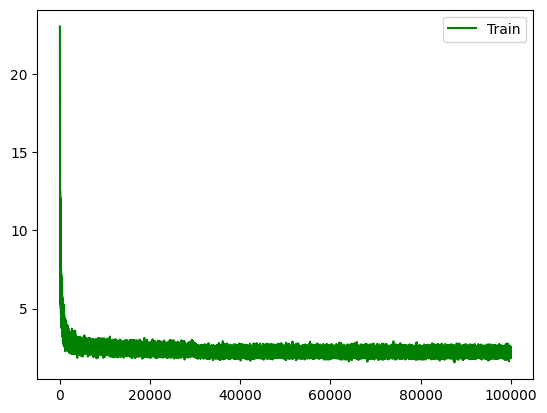

In [12]:
# Plotting training and validation losses
xs = list(range(1, len(losses["Train"])+1))
plt.plot(xs, losses["Train"], label = "Train", color="green")
#plt.plot(xs, losses["Val"], label = "Valid", color="red")
plt.legend()
plt.show()

In [13]:
split_loss("train", print_loss=True)
split_loss("valid", print_loss=True)

train 2.203683376312256
valid 2.227872610092163


# Generating Names

In [14]:
number_of_names = 20

for _ in range(number_of_names):
    
    char_idx = []
    context = [0] * block_size # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # Embeddings for context
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        char_idx.append(idx)
        if idx == 0:
            break
    
    print(''.join(idx_to_chr[char_idx] for char_idx in char_idx))

eurothvimineh.
istin.
keis.
kravie.
granna.
tarea.
mariseerel.
soldyy.
shy.
bora.
kaera.
sevin.
zaiya.
well.
mic.
jahia.
tesasanrrong.
aigh.
wytin.
soppe.


# Analyses
We will now go through the model above and find out how to make it better.

### Initialization: Part I
If we look at the losses output by the model, we can see that the initial loss is way higher than all the training losses. This is of cause expected, at we initialize the weights using random numbers. But there are things we can do to ensure a better initial loss. E.g. we attempt to make sure that the initial model predicts the 27 output-letters uniformly in stead of randomly. 

We will start out by calculating the expected initial loss if the propabilities of the outputs were uniformly distributed.

In [15]:
# Estimating the loss at uniform distribution
-torch.tensor(1/27).log()

tensor(3.2958)

We can illustrate this example further by comparing the loss for a uniformly distributed tensor vs a randomly initialized tensor.

In [16]:
# Uniform
logits = torch.tensor([0.15,0.15,0.15,0.15])
probs = torch.softmax(logits, dim=0)
losses = -probs.log()
logits, probs, losses

(tensor([0.1500, 0.1500, 0.1500, 0.1500]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([1.3863, 1.3863, 1.3863, 1.3863]))

In [17]:
# Random
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
losses = -probs.log()
logits, probs, losses

(tensor([ 0.2798, -0.7476,  0.9403, -0.5602]),
 tensor([0.2684, 0.0961, 0.5196, 0.1159]),
 tensor([1.3152, 2.3426, 0.6547, 2.1552]))

We can see that the logits of the randomly initialized tensor have more "extreme" values than those from the uniform distribution. If we break the training loop for our model (above) after one epoch, we can also inspect the logits there, and conclude that the logits contain "extreme" values.

We will now attempt to find a way to make the initial loss lower by initializing the weights, such that the logits will be uniformly distributed (it is the most easy just to get them to all very close to zero).

We make the logits closer to zero in the following part of the network:

* logits = h @ W2 + b2
  * We can see that the biases **b2** adds directly to the logits. By initializing **b2** as zero, we can move the logits closer to zero.
  * We can also scale down **W2** to get the logits closer to zero.

In [18]:
# Attempt 1: Logits towards zero
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden])
b1 = torch.randn([n_hidden])
W2 = torch.randn([n_hidden, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


In [19]:
# Attempt 1: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.3194
  10000/ 100000: 2.3700
  20000/ 100000: 2.5972
  30000/ 100000: 2.3189
  40000/ 100000: 2.0711
  50000/ 100000: 1.7873
  60000/ 100000: 1.9657
  70000/ 100000: 2.1261
  80000/ 100000: 2.1425
  90000/ 100000: 2.0025
train 2.105613946914673
valid 2.1430580615997314


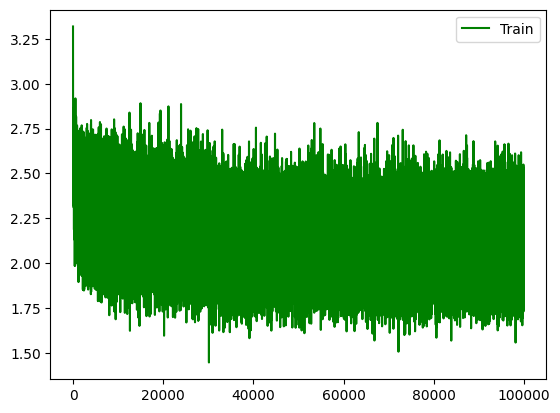

In [20]:
# Attempt 1: Plotting training and validation losses
xs = list(range(1, len(losses["Train"])+1))
plt.plot(xs, losses["Train"], label = "Train", color="green")
#plt.plot(xs, losses["Val"], label = "Valid", color="red")
plt.legend()
plt.show()

### Initialization: Part II
This time we will be taking a look at the activations. That is, we will be looking at this part of the forward pass:

* h = torch.tanh(h_preactiv)

What **tanh** does is to squeeze the pre-activation-values to numbers between -1 and 1. Now we will inspect **h** after one epoch (do this manually with break).

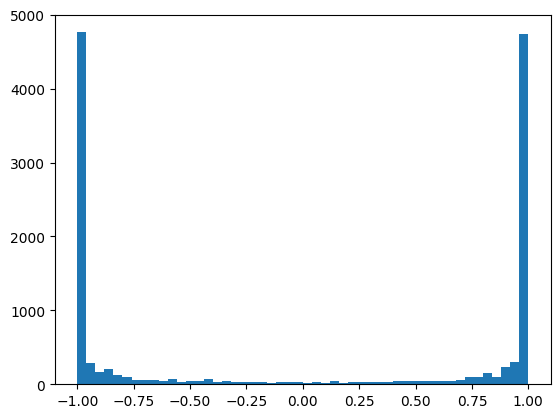

In [21]:
# Plotting distribution of h values
plt.hist(h.view(-1).tolist(), 50);

We can see that **tanh** is very active. The reason for this can be found by taking a few steps back.

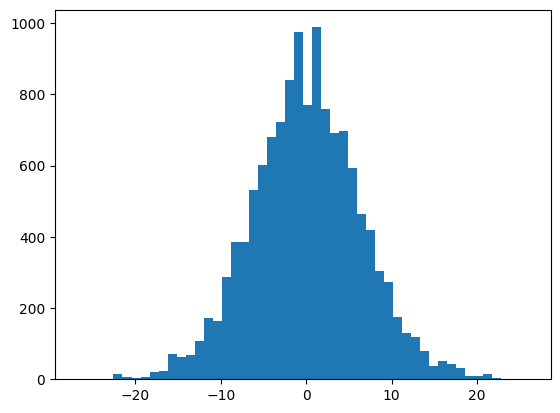

In [22]:
# Distribution of pre-activations
plt.hist(h_preactiv.view(-1).tolist(), 50);

We can see that the **pre-activations** are distributed between roughly -20 and 20. In the next plot we have plottet values between -20 and 20 versus tanh of the values.

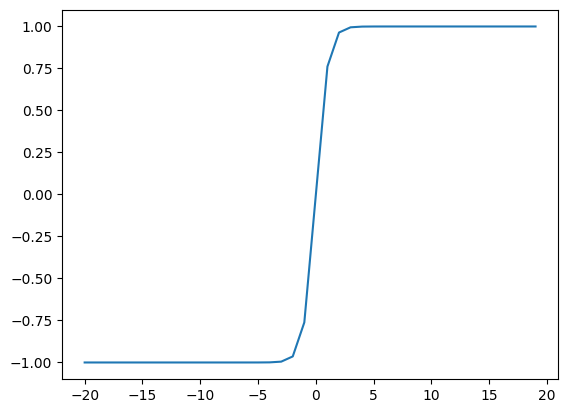

In [23]:
# Values vs tanh(values)
x1 = torch.tensor(range(-20,20,1))
y1 = torch.tanh(x1)
plt.plot(x1,y1)

It is now clear why most of the values get bumped to -1 and 1, as values above 6 and below -6 will be bumped to 1 and -1 respectively. When calculating the gradient during the backward pass, the gradient of the activations is being killed because:

self.grad += (1 - t\*\*2) * out.grad 

As we can see:

self.grad += 0 * out.grad

If the the activation instead had been close to zero, the out.grad would just be passed along. Let's examine how bed it looks for out neurons.

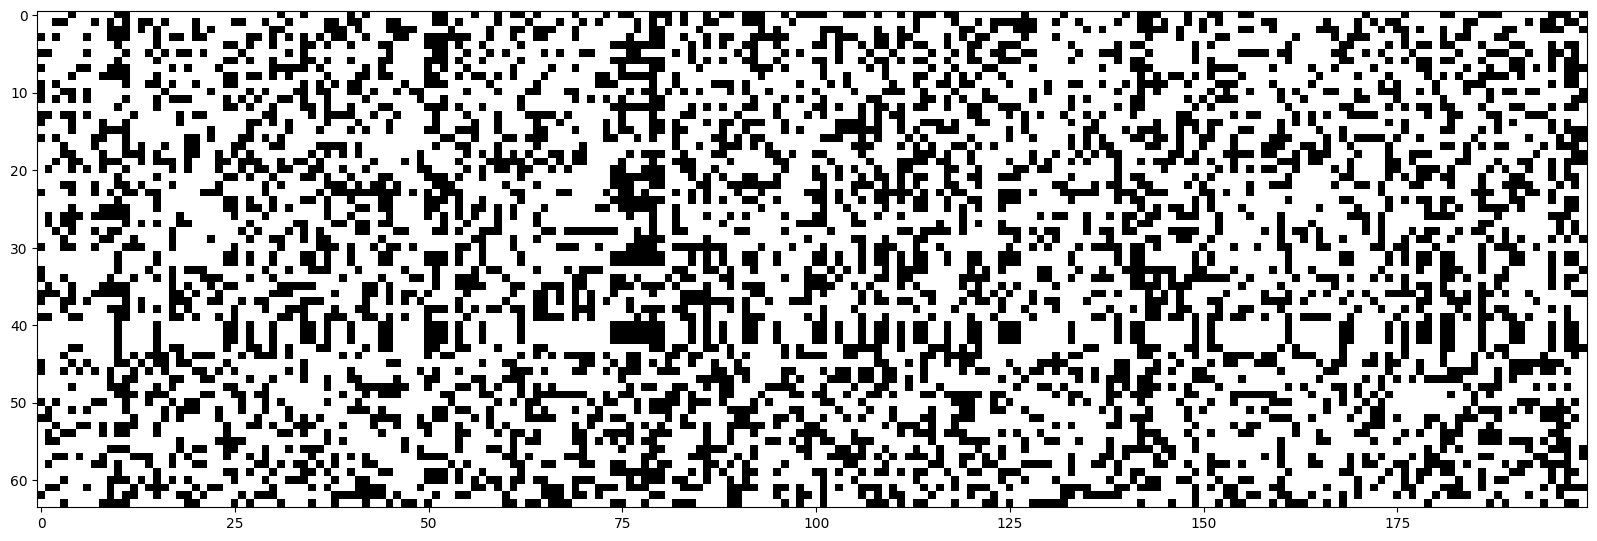

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Each column is a neuron, and it column is fully black it means that the neuron is dead, and information can no longer flow through it. That is, no matter what data you feed the neuron it can only fire as 1 or -1.

This problem is not unique to tahn as an activation function:

* Sigmoid: Values under/over -10/10 get squashed to -1/1
* ReLU: Values under zero get squashed to 0
* leaky-ReLU: Doesn't really suffer from this problem
* ELU: Has the same problem for negative values

The problem can be created at initialization but also during training. So the way we solve the problem is by looking at the following equation:

* h_preactiv = emb_cat @ W1 + b1

We want h_preactiv to be closer to zero, and this can be done by setting the b1 to zero and multiplying the W1 by a low number.

In [25]:
# Attempt 2: Pre-activations towards zero
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden]) * 0.15
b1 = torch.randn([n_hidden]) * 0
W2 = torch.randn([n_hidden, vocab_size]) * 0.01
b2 = torch.randn([vocab_size]) * 0

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


In [26]:
# Attempt 2: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")
    break

split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.3094
train 3.2528674602508545
valid 3.2528977394104004


We are doing the same diagnosis again.

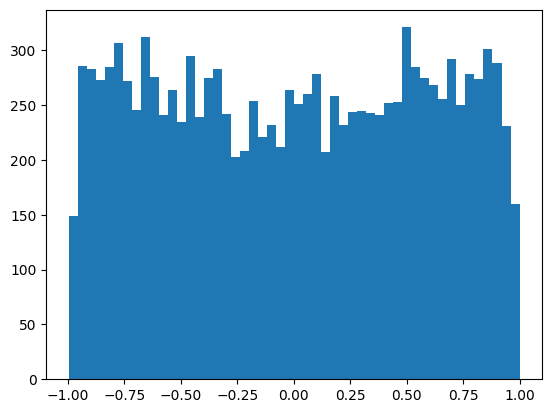

In [27]:
# Plotting distribution of h values
plt.hist(h.view(-1).tolist(), 50);

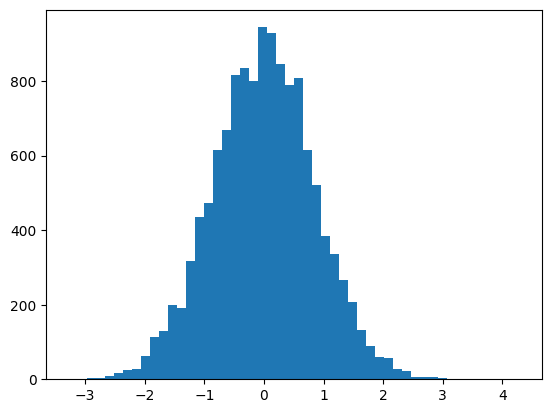

In [28]:
# Distribution of pre-activations
plt.hist(h_preactiv.view(-1).tolist(), 50);

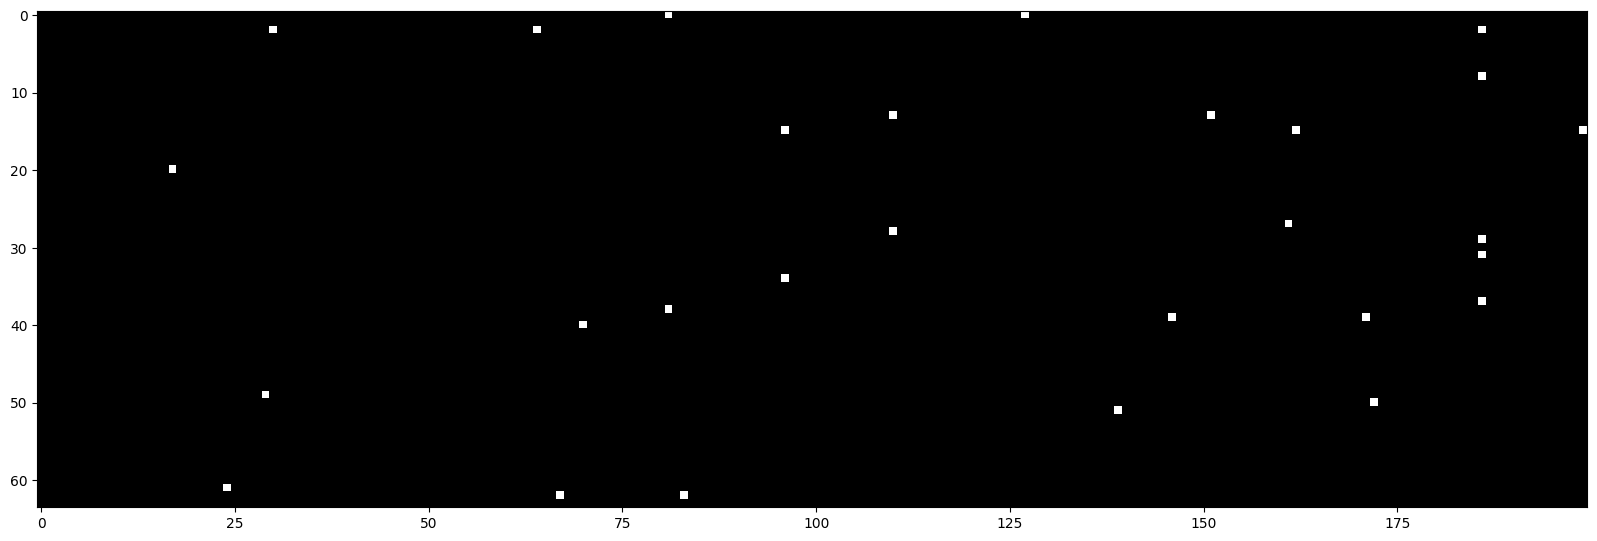

In [29]:
# If all black because no neurons are larger than 0.99
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Now that it looks much better, we can train the network again.

In [30]:
# Attempt 2: Training
losses = {"Train": [], "Val": []}
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))
    
    # Printing stats
    if not epoch % 10000:
        print(f"{epoch:7d}/{epochs:7d}: {loss.item():.4f}")

split_loss('train', print_loss=True)
split_loss('valid', print_loss=True)

      0/ 100000: 3.2609
  10000/ 100000: 2.4368
  20000/ 100000: 2.0814
  30000/ 100000: 2.2230
  40000/ 100000: 1.9072
  50000/ 100000: 1.9870
  60000/ 100000: 2.0982
  70000/ 100000: 2.0021
  80000/ 100000: 2.0940
  90000/ 100000: 2.2873
train 2.0671584606170654
valid 2.1055519580841064


The model is now performing quite a bit better!

### Initialization: Part 3

In [31]:
### CONTINUE: http://www.youtube.com/watch?v=P6sfmUTpUmc&t=27m50s

In [32]:
# https://www.youtube.com/watch?v=P6sfmUTpUmc